In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import scipy
import scipy.io as sio
from scipy.integrate import solve_ivp, odeint
from utility_functions import sparsifyDynamics, poolData

### Load Data and Scale 

In [45]:
# load saved data from .mat file
data = sio.loadmat('../models/data/REFSIM-25hr.mat', chars_as_strings=1)
t = data['t'].squeeze()
x = data['x']
names = data['names']
names = np.array([str(''.join(letter)) for letter_array in names for letter in letter_array])
# print(names)

# only keep non-constant data
dynamics = [0,1,2,3,4,5,6,7,8,9]
x = x[:, dynamics]
names = names[dynamics]
names = ['Arterial', 'Gut', 'GutLumen', 'Lung', 'Venous', 'Rest', 'Liver', 'Metab', 'Kidney', 'Tubules']

# scale all data from Mols/L to milliMols/L (which equals microMol/mL)
x *= 1000

print(x.shape)
print(names)


(130, 10)
['Arterial', 'Gut', 'GutLumen', 'Lung', 'Venous', 'Rest', 'Liver', 'Metab', 'Kidney', 'Tubules']


### Plot Data

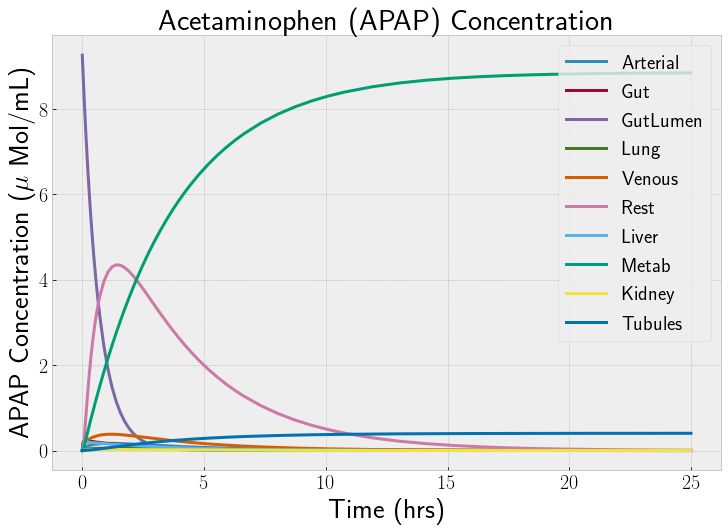

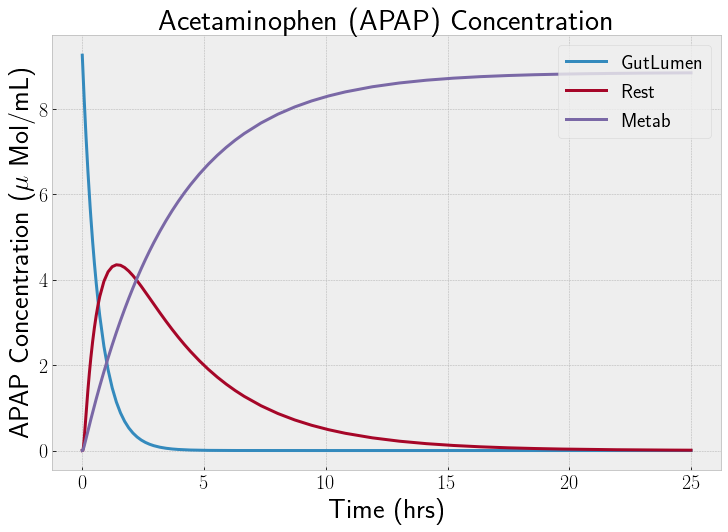

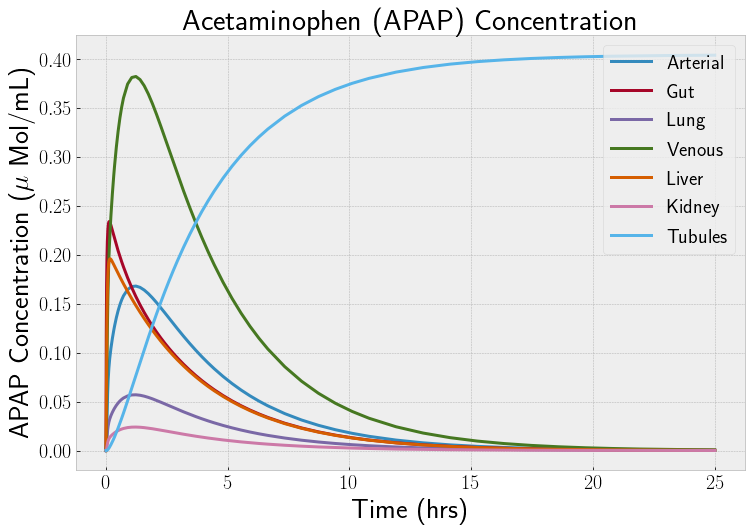

In [56]:
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
# print(plt.style.available)
plt.rcParams['font.size'] = 26
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

# plot the amount of APAP in venous blood over time
# venousAPAPInLiters = x[:, 5] / 3.41;
# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(t, venousAPAPInLiters)
# plt.xlabel('Time (hrs)')
# plt.ylabel(names[5] + r' APAP ($\mu$ Mol/mL)')
# plt.title('Acetaminophen (APAP) Metabolism')
# plt.show()

compartments = dynamics

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [2,5,7]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [0,1,3,4,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

### Run SINDy Algorithm

In [47]:
# Run SINDy algorithm
xdf = pd.DataFrame(x)
n, nVars = x.shape
xdf_dot = xdf.diff()

# we lose one row, need to zero pad (or maybe not)
#x_dot = pd.concat([pd.DataFrame(np.zeros((1, nVars))), x_dot])
xdf_dot.loc[0, :] = 0.0

# variable labeling
cols = [i for i in names]
xdf.columns = cols
dot_labels = pd.Index([s for s in cols])

# SINDy params
polyorder = 3
lam = 0.0001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(xdf, nVars, polyorder, usesine)

# run SINDy
xdf_hat = sparsifyDynamics(Theta, xdf_dot, lam, 100000)
xdf_hat = xdf_hat.set_index(dot_labels)
print(xdf_hat.shape)
print('nonzeros:' + str(np.count_nonzero(xdf_hat)))


(10, 286)
nonzeros:48


### Display Results and Save

In [48]:
# Save to csv
xdf_hat.to_csv('../models/data/dynamics.csv')
# Display results except rows/cols that have all zeros
xdf_hat.T.loc[np.logical_and((xdf_hat.T!=0).any(axis=1), (xdf_hat!=0).any(axis=0))]

,Arterial,Gut,GutLumen,Lung,Venous,Rest,Liver,Metab,Kidney,Tubules
GutLumen,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000e+00,-0.000000,0.0,-0.000067
Rest,-0.000000,-0.000669,0.000000,-0.0,-0.000000,-0.000000,-6.159823e-04,0.000000,-0.0,0.000000
Metab,-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.001910,-0.000000e+00,0.000000,-0.0,0.000000
Kidney,0.000000,-0.083958,-0.000000,0.0,0.000000,0.000000,-0.000000e+00,0.000000,0.0,0.000000
"(Arterial, GutLumen)",0.000000,-0.000000,-0.036474,0.0,0.000000,0.000000,-0.000000e+00,0.000000,0.0,-0.000000
"(Gut, GutLumen)",0.000000,0.000000,-0.010973,0.0,0.002561,0.000000,0.000000e+00,0.000000,0.0,-0.000000
"(Gut, Metab)",-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-2.183186e-03,0.000000,-0.0,0.000000
"(Gut, Tubules)",-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.0,0.370972
"(GutLumen, Lung)",0.000000,-0.000000,-0.030694,0.0,0.000000,0.000000,-0.000000e+00,0.000000,0.0,-0.000000
"(GutLumen, Venous)",0.000798,-0.000000,-0.006935,0.0,0.002803,0.000000,-0.000000e+00,0.000000,0.0,-0.000000


### Use SINDy Results for Simulation

In [49]:
def sparseGalerkin(t, y):
    return np.matmul(
        zdf_hat.values,
        poolData(pd.DataFrame(y).T, nVars, polyorder, usesine).values.T
    ).squeeze()

x0 = xdf.iloc[0].values

# tB, xB = t, predicted_linear_trajectory(x0, xdf_hat, t)
# tB, xB = t, odeint(sparseGalerkin, x0, t, tfirst=True)
result = solve_ivp(sparseGalerkin, [t[0], t[-1]], z0)
tB, xB = result.t, result.y.T
print(xB.shape)


(6, 10)


### Graph SINDy Simulation Results

ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

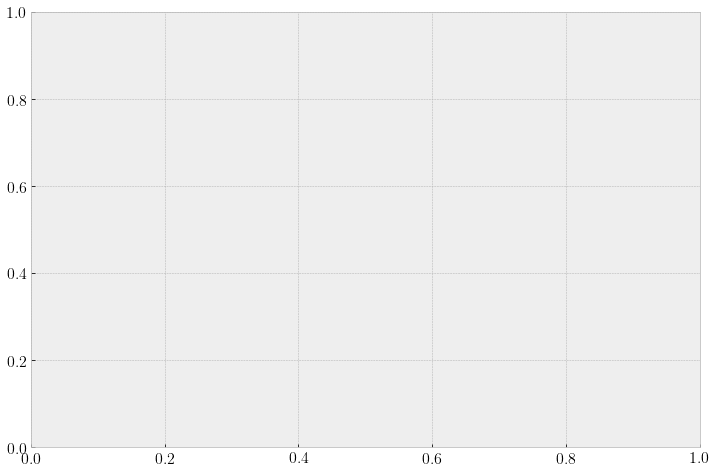

In [60]:
# Graph solution
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
# print(plt.style.available)
plt.rcParams['font.size'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

compartments = dynamics

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [2,5,7]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [0,1,3,4,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

### Augment Data

In [57]:
# increase data to handle all transport functions (Art -> Gut, Lung -> Tubules, etc)
z_rows, length = x.shape
z_columns = scipy.special.comb(len(names), 2, exact=True)
# z_columns = len(names) + scipy.special.comb(len(names), 2, exact=True)
z = np.zeros((z_rows, z_columns))
# z[:, 0:length] = x
z_names = []
# index = 10
index = 0
for x1 in np.arange(length):
    for x2 in np.arange(x1+1, length):
        z[:, index] = x[:, x2] - x[:, x1]
        index += 1
        z_names.append(names[x1] + '-' + names[x2])
# z_names = names + z_names
print(z.shape)
print(z_names)


(130, 45)
['Arterial-Gut', 'Arterial-GutLumen', 'Arterial-Lung', 'Arterial-Venous', 'Arterial-Rest', 'Arterial-Liver', 'Arterial-Metab', 'Arterial-Kidney', 'Arterial-Tubules', 'Gut-GutLumen', 'Gut-Lung', 'Gut-Venous', 'Gut-Rest', 'Gut-Liver', 'Gut-Metab', 'Gut-Kidney', 'Gut-Tubules', 'GutLumen-Lung', 'GutLumen-Venous', 'GutLumen-Rest', 'GutLumen-Liver', 'GutLumen-Metab', 'GutLumen-Kidney', 'GutLumen-Tubules', 'Lung-Venous', 'Lung-Rest', 'Lung-Liver', 'Lung-Metab', 'Lung-Kidney', 'Lung-Tubules', 'Venous-Rest', 'Venous-Liver', 'Venous-Metab', 'Venous-Kidney', 'Venous-Tubules', 'Rest-Liver', 'Rest-Metab', 'Rest-Kidney', 'Rest-Tubules', 'Liver-Metab', 'Liver-Kidney', 'Liver-Tubules', 'Metab-Kidney', 'Metab-Tubules', 'Kidney-Tubules']


### Run SINDy Algorithm on Augmented Data

In [58]:
# Run SINDy algorithm
zdf = pd.DataFrame(z)
n, nVars = z.shape
zdf_dot = zdf.diff()

# we lose one row, need to zero pad (or maybe not)
#x_dot = pd.concat([pd.DataFrame(np.zeros((1, nVars))), x_dot])
zdf_dot.loc[0, :] = 0.0

# variable labeling
cols = [i for i in z_names]
zdf.columns = cols
dot_labels = pd.Index([s for s in cols])

# SINDy params
polyorder = 3
lam = 0.0001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(zdf, nVars, polyorder, usesine)

# run SINDy
zdf_hat = sparsifyDynamics(Theta, zdf_dot, lam, 100000)
zdf_hat = zdf_hat.set_index(dot_labels)
print(zdf_hat.shape)
print('nonzeros:' + str(np.count_nonzero(zdf_hat)))


(45, 17296)
nonzeros:444


### Use SINDy Results on Augmented Data for Simulation

In [62]:
def sparseGalerkin(t, y):
    return np.matmul(
        zdf_hat.values,
        poolData(pd.DataFrame(y).T, nVars, polyorder, usesine).values.T
    ).squeeze()

z0 = zdf.iloc[0].values

# tB, xB = t, predicted_linear_trajectory(x0, xdf_hat, t)
# tB, xB = t, odeint(sparseGalerkin, x0, t, tfirst=True)
result = solve_ivp(sparseGalerkin, [t[0], t[-1]], z0)
tB, zB = result.t, result.y.T
print(tB.shape)
print(zB.shape)

(5,)
(5, 45)


### Graph Augmented Data Simulation Results

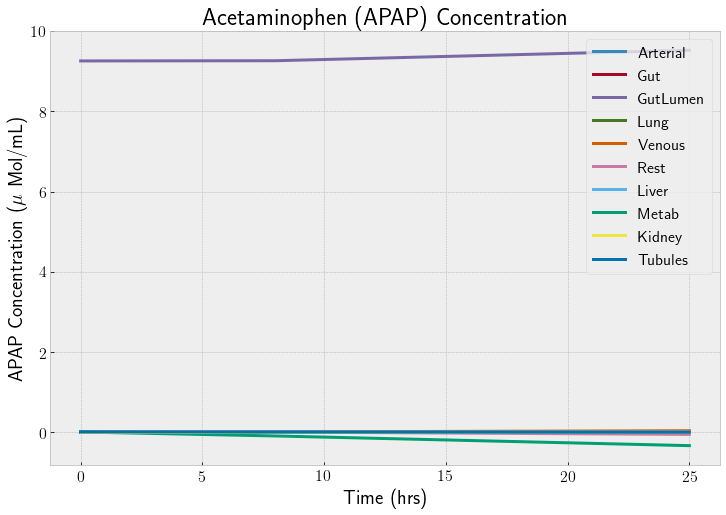

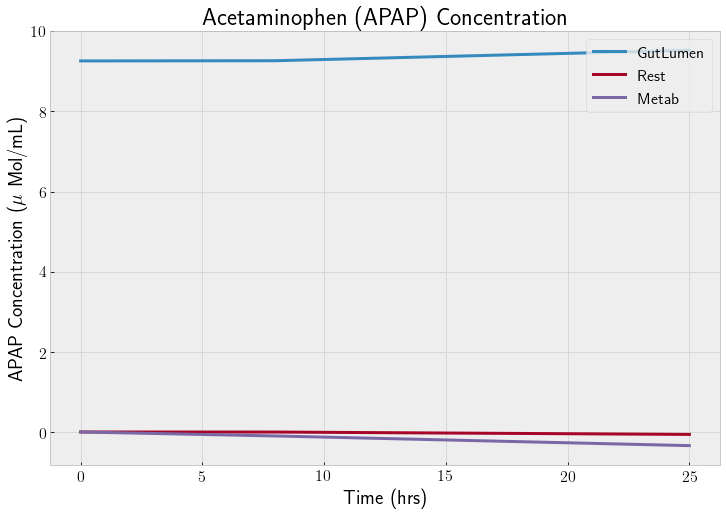

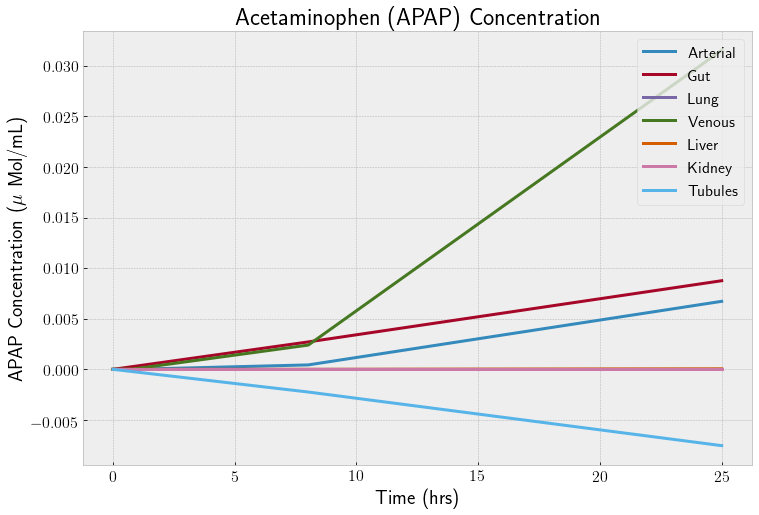

In [54]:
# Graph solution
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
# print(plt.style.available)
plt.rcParams['font.size'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

compartments = dynamics

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, zB[:, c], label=z_names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [2,5,7]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, zB[:, c], label=z_names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [0,1,3,4,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(tB, zB[:, c], label=z_names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

### Display Augmented Data Results and Save

In [55]:
# Save to csv
zdf_hat.to_csv('../models/data/dynamics_augmented.csv')
# Display results except rows/cols that have all zeros
zdf_hat.T.loc[np.logical_and((zdf_hat.T!=0).any(axis=1), (zdf_hat!=0).any(axis=0))]

,Arterial,Gut,GutLumen,Lung,Venous,Rest,Liver,Metab,Kidney,Tubules,...,Rest-Liver,Rest-Metab,Rest-Kidney,Rest-Tubules,Liver-Metab,Liver-Kidney,Liver-Tubules,Metab-Kidney,Metab-Tubules,Kidney-Tubules
Gut,0.000000,-0.000000e+00,-0.120377,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Venous,0.000000,-0.000000e+00,-0.000000,0.0,0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
Liver,0.000000,-0.000000e+00,-0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
Arterial-Venous,0.000000,-0.000000e+00,-0.000000,0.0,0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
Gut-Lung,-0.000000,-0.000000e+00,0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gut-Venous,-0.000000,-1.978881e-02,-0.000000,-0.0,-0.000000,-0.000000,-0.007975,0.000000,-0.0,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030208,-0.000000,-0.000000,0.000000
Gut-Tubules,-0.000000,-0.000000e+00,0.000000,-0.0,-0.001612,-0.000000,-0.000000,0.000000,-0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
GutLumen-Rest,-0.000000,-0.000000e+00,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,0.000000,-0.0,0.000030,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000062,-0.000000,-0.000000,0.000033
GutLumen-Metab,-0.000000,-0.000000e+00,0.000000,-0.0,-0.000000,-0.000000,-0.000000,0.000000,-0.0,0.000000,...,0.000000,0.001296,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
GutLumen-Tubules,-0.000000,-0.000000e+00,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,0.000000,-0.0,0.000000,...,0.000000,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
